# Recommendation using embeddings and nearest neighbor search

Recommendations are widespread across the web.

- 'Bought that item? Try these similar items.'
- 'Enjoy that book? Try these similar titles.'
- 'Not the help page you were looking for? Try these similar pages.'

This notebook demonstrates how to use embeddings to find similar items to recommend. In particular, we use [AG's corpus of news articles](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) as our dataset.

Our model will answer the question: given an article, what other articles are most similar to it?

### 1. Imports

First, let's import the packages and functions we'll need for later. If you don't have these, you'll need to install them. You can install them via your terminal by running `pip install {package_name}`, e.g. `pip install pandas`.

In [1]:
# imports
import pandas as pd
import pickle

from openai.embeddings_utils import (
    get_embedding,
    distances_from_embeddings,
    tsne_components_from_embeddings,
    chart_from_components,
    indices_of_nearest_neighbors_from_distances,
)


### 2. Load data

Next, let's load the AG news data and see what it looks like.

In [2]:
# load data (full dataset available at http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)
dataset_path = "https://cdn.openai.com/API/examples/data/AG_news_samples.csv"
df = pd.read_csv(dataset_path)

# print dataframe
n_examples = 5
df.head(n_examples)

,title,description,label_int,label
0,World Briefings,BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime M...,1,World
1,Nvidia Puts a Firewall on a Motherboard (PC Wo...,PC World - Upcoming chip set will include buil...,4,Sci/Tech
2,"Olympic joy in Greek, Chinese press",Newspapers in Greece reflect a mixture of exhi...,2,Sports
3,U2 Can iPod with Pictures,"SAN JOSE, Calif. -- Apple Computer (Quote, Cha...",4,Sci/Tech
4,The Dream Factory,"Any product, any shape, any size -- manufactur...",4,Sci/Tech


Let's take a look at those same examples, but not truncated by ellipses.

In [3]:
# print the title, description, and label of each example
for idx, row in df.head(n_examples).iterrows():
    print("")
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Label: {row['label']}")


Title: World Briefings
Description: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.
Label: World

Title: Nvidia Puts a Firewall on a Motherboard (PC World)
Description: PC World - Upcoming chip set will include built-in security features for your PC.
Label: Sci/Tech

Title: Olympic joy in Greek, Chinese press
Description: Newspapers in Greece reflect a mixture of exhilaration that the Athens Olympics proved successful, and relief that they passed off without any major setback.
Label: Sports

Title: U2 Can iPod with Pictures
Description: SAN JOSE, Calif. -- Apple Computer (Quote, Chart) unveiled a batch of new iPods, iTunes software and promos designed to keep it atop the heap of digital music players.
Label: Sci/Tech

Title: The Dream Factory
Description: Any product, any shape, any size -- manufactured o

### 3. Build cache to save embeddings

Before getting embeddings for these articles, let's set up a cache to save the embeddings we generate. In general, it's a good idea to save your embeddings so you can re-use them later. If you don't save them, you'll pay again each time you compute them again.

To save you the expense of computing the embeddings needed for this demo, we've provided a pre-filled cache via the URL below. The cache is a dictionary that maps tuples of `(text, engine)` to a `list of floats` embedding. The cache is saved as a Python pickle file.

In [4]:
# establish a cache of embeddings to avoid recomputing
# cache is a dict of tuples (text, engine) -> embedding, saved as a pickle file

# set path to embedding cache
embedding_cache_path_to_load = "example_embeddings_cache.pkl"
embedding_cache_path_to_save = "example_embeddings_cache.pkl"

# load the cache if it exists, and save a copy to disk
try:
    embedding_cache = pd.read_pickle(embedding_cache_path_to_load)
except FileNotFoundError:
    embedding_cache = {}
with open(embedding_cache_path_to_save, "wb") as embedding_cache_file:
    pickle.dump(embedding_cache, embedding_cache_file)

# define a function to retrieve embeddings from the cache if present, and otherwise request via the API
def embedding_from_string(
    string: str,
    engine: str = "text-embedding-ada-002",
    embedding_cache=embedding_cache
) -> list:
    """Return embedding of given string, using a cache to avoid recomputing."""
    if (string, engine) not in embedding_cache.keys():
        embedding_cache[(string, engine)] = get_embedding(string, engine)
        with open(embedding_cache_path_to_save, "wb") as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(string, engine)]

Let's check that it works by getting an embedding.

In [5]:
# as an example, take the first description from the dataset
example_string = df["description"].values[0]
print(f"\nExample string: {example_string}")

# print the first 10 dimensions of the embedding
example_embedding = embedding_from_string(example_string)
print(f"\nExample embedding: {example_embedding[:10]}...")


Example string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

Example embedding: [-0.010660368017852306, -0.022390639409422874, -0.008842820301651955, -0.025445666164159775, 0.03140103444457054, 0.010763490572571754, -0.016757531091570854, 0.004205495584756136, -0.008024279028177261, -0.02146252989768982]...


### 4. Recommend similar articles based on embeddings

To find similar articles, let's follow a three-step plan:
1. Get the similarity embeddings of all the article descriptions
2. Calculate the distance between a source title and all other articles
3. Print out the other articles closest to the source title

In [6]:
def print_recommendations_from_strings(
    strings: list[str],
    index_of_source_string: int,
    k_nearest_neighbors: int = 1,
    engine="text-embedding-ada-002",
) -> list[int]:
    """Print out the k nearest neighbors of a given string."""
    # get embeddings for all strings
    embeddings = [embedding_from_string(string, engine=engine) for string in strings]
    # get the embedding of the source string
    query_embedding = embeddings[index_of_source_string]
    # get distances between the source embedding and other embeddings (function from embeddings_utils.py)
    distances = distances_from_embeddings(query_embedding, embeddings, distance_metric="cosine")
    # get indices of nearest neighbors (function from embeddings_utils.py)
    indices_of_nearest_neighbors = indices_of_nearest_neighbors_from_distances(distances)

    # print out source string
    query_string = strings[index_of_source_string]
    print(f"Source string: {query_string}")
    # print out its k nearest neighbors
    k_counter = 0
    for i in indices_of_nearest_neighbors:
        # skip any strings that are identical matches to the starting string
        if query_string == strings[i]:
            continue
        # stop after printing out k articles
        if k_counter >= k_nearest_neighbors:
            break
        k_counter += 1

        # print out the similar strings and their distances
        print(
            f"""
        --- Recommendation #{k_counter} (nearest neighbor {k_counter} of {k_nearest_neighbors}) ---
        String: {strings[i]}
        Distance: {distances[i]:0.3f}"""
        )

    return indices_of_nearest_neighbors

### 5. Example recommendations

Let's look for articles similar to first one, which was about Tony Blair.

In [7]:
article_descriptions = df["description"].tolist()

tony_blair_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=0,  # let's look at articles similar to the first one about Tony Blair
    k_nearest_neighbors=5,  # let's look at the 5 most similar articles
)

Source string: BRITAIN: BLAIR WARNS OF CLIMATE THREAT Prime Minister Tony Blair urged the international community to consider global warming a dire threat and agree on a plan of action to curb the  quot;alarming quot; growth of greenhouse gases.

        --- Recommendation #1 (nearest neighbor 1 of 5) ---
        String: THE re-election of British Prime Minister Tony Blair would be seen as an endorsement of the military action in Iraq, Prime Minister John Howard said today.
        Distance: 0.153

        --- Recommendation #2 (nearest neighbor 2 of 5) ---
        String: LONDON, England -- A US scientist is reported to have observed a surprising jump in the amount of carbon dioxide, the main greenhouse gas.
        Distance: 0.160

        --- Recommendation #3 (nearest neighbor 3 of 5) ---
        String: The anguish of hostage Kenneth Bigley in Iraq hangs over Prime Minister Tony Blair today as he faces the twin test of a local election and a debate by his Labour Party about the di

Pretty good! 4 of the 5 recommendations explicitly mention Tony Blair and the fifth is an article from London about climate change, topics that might be often associated with Tony Blair.

Let's see how our recommender does on the second example article about NVIDIA's new chipset with more security.

In [8]:
chipset_security_articles = print_recommendations_from_strings(
    strings=article_descriptions,  # let's base similarity off of the article description
    index_of_source_string=1,  # let's look at articles similar to the second one about a more secure chipset
    k_nearest_neighbors=5,  # let's look at the 5 most similar articles
)

Source string: PC World - Upcoming chip set will include built-in security features for your PC.

        --- Recommendation #1 (nearest neighbor 1 of 5) ---
        String: PC World - Updated antivirus software for businesses adds intrusion prevention features.
        Distance: 0.112

        --- Recommendation #2 (nearest neighbor 2 of 5) ---
        String: PC World - The one-time World Class Product of the Year PDA gets a much-needed upgrade.
        Distance: 0.145

        --- Recommendation #3 (nearest neighbor 3 of 5) ---
        String: PC World - Send your video throughout your house--wirelessly--with new gateways and media adapters.
        Distance: 0.153

        --- Recommendation #4 (nearest neighbor 4 of 5) ---
        String: PC World - Symantec, McAfee hope raising virus-definition fees will move users to\  suites.
        Distance: 0.157

        --- Recommendation #5 (nearest neighbor 5 of 5) ---
        String: Gateway computers will be more widely available at Of

From the printed distances, you can see that the #1 recommendation is much closer than all the others (0.11 vs 0.15+). And the #1 recommendation looks very similar to the starting article - it's another article from PC World about increasing computer security. Pretty good! 

## Appendix: Using embeddings in more sophisticated recommenders

A more sophisticated way to build a recommender system is to train a machine learning model that takes in tens or hundreds of signals, such as item popularity or user click data. Even in this system, embeddings can be a very useful signal into the recommender, especially for items that are being 'cold started' with no user data yet (e.g., a brand new product added to the catalog without any clicks yet).

## Appendix: Using embeddings to visualize similar articles

To get a sense of what our nearest neighbor recommender is doing, let's visualize the article embeddings. Although we can't plot the 2048 dimensions of each embedding vector, we can use techniques like [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) or [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) to compress the embeddings down into 2 or 3 dimensions, which we can chart.

Before visualizing the nearest neighbors, let's visualize all of the article descriptions using t-SNE. Note that t-SNE is not deterministic, meaning that results may vary from run to run.

/Users/ted/.virtualenvs/openai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


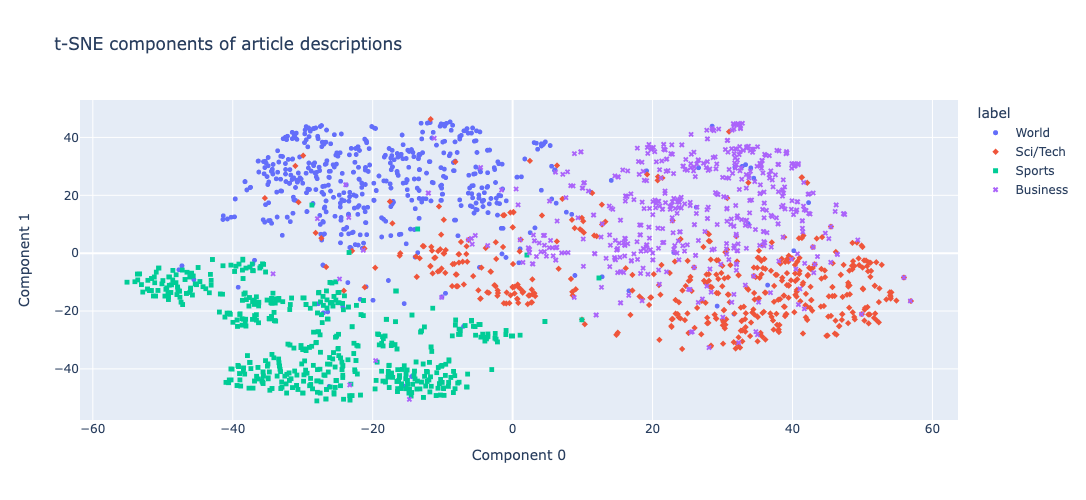

In [9]:
# get embeddings for all article descriptions
embeddings = [embedding_from_string(string) for string in article_descriptions]
# compress the 2048-dimensional embeddings into 2 dimensions using t-SNE
tsne_components = tsne_components_from_embeddings(embeddings)
# get the article labels for coloring the chart
labels = df["label"].tolist()

chart_from_components(
    components=tsne_components,
    labels=labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="t-SNE components of article descriptions",
)

As you can see in the chart above, even the highly compressed embeddings do a good job of clustering article descriptions by category. And it's worth emphasizing: this clustering is done with no knowledge of the labels themselves!

Also, if you look closely at the most egregious outliers, they are often due to mislabeling rather than poor embedding. For example, the majority of the blue World points in the green Sports cluster appear to be Sports stories.

Next, let's recolor the points by whether they are a source article, its nearest neighbors, or other.

In [10]:
# create labels for the recommended articles
def nearest_neighbor_labels(
    list_of_indices: list[int],
    k_nearest_neighbors: int = 5
) -> list[str]:
    """Return a list of labels to color the k nearest neighbors."""
    labels = ["Other" for _ in list_of_indices]
    source_index = list_of_indices[0]
    labels[source_index] = "Source"
    for i in range(k_nearest_neighbors):
        nearest_neighbor_index = list_of_indices[i + 1]
        labels[nearest_neighbor_index] = f"Nearest neighbor (top {k_nearest_neighbors})"
    return labels


tony_blair_labels = nearest_neighbor_labels(tony_blair_articles, k_nearest_neighbors=5)
chipset_security_labels = nearest_neighbor_labels(chipset_security_articles, k_nearest_neighbors=5
)

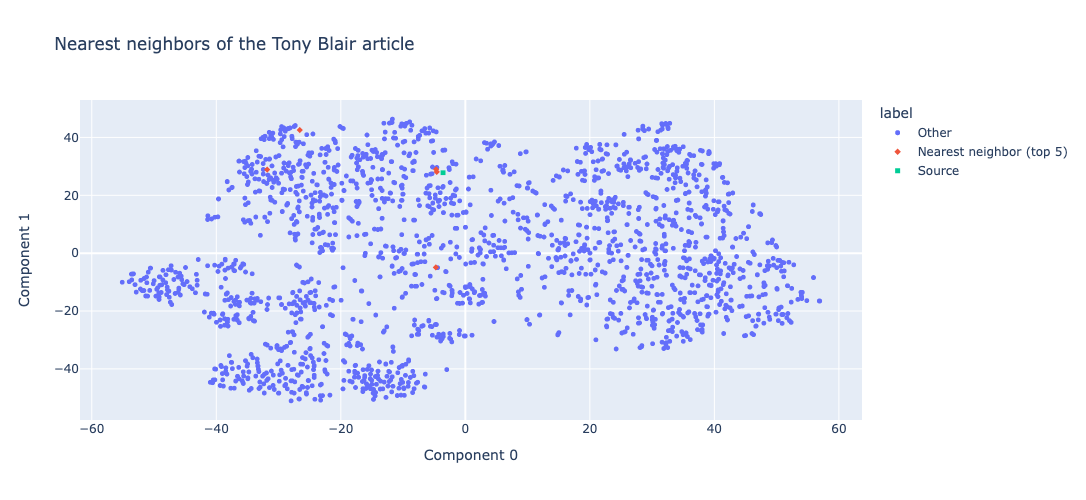

In [11]:
# a 2D chart of nearest neighbors of the Tony Blair article
chart_from_components(
    components=tsne_components,
    labels=tony_blair_labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="Nearest neighbors of the Tony Blair article",
    category_orders={"label": ["Other", "Nearest neighbor (top 5)", "Source"]},
)

Looking at the 2D chart above, we can see that the articles about Tony Blair are somewhat close together inside of the World news cluster. Interestingly, although the 5 nearest neighbors (red) were closest in high dimensional space, they are not the closest points in this compressed 2D space. Compressing the embeddings down to 2 dimensions discards much of their information, and the nearest neighbors in the 2D space don't seem to be as relevant as those in the full embedding space.

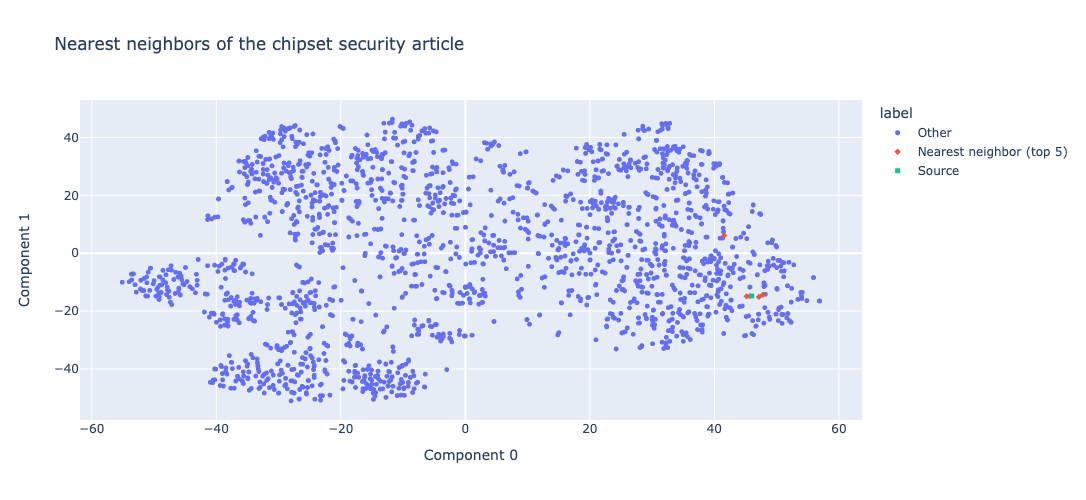

In [12]:
# a 2D chart of nearest neighbors of the chipset security article
chart_from_components(
    components=tsne_components,
    labels=chipset_security_labels,
    strings=article_descriptions,
    width=600,
    height=500,
    title="Nearest neighbors of the chipset security article",
    category_orders={"label": ["Other", "Nearest neighbor (top 5)", "Source"]},
)

For the chipset security example, the 4 closest nearest neighbors in the full embedding space remain nearest neighbors in this compressed 2D visualization. The fifth is displayed as more distant, despite being closer in the full embedding space.

Should you want to, you can also make an interactive 3D plot of the embeddings with the function `chart_from_components_3D`. (Doing so will require recomputing the t-SNE components with `n_components=3`.)